In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import json
import numpy as np
import os

from sklearn import metrics

pd.set_option('display.max_rows', 500)

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# AAFC Salmonella AMR Analysis

Analyses of the 97 broiler chicken derived _Salmonella_ from BC (via AAFC and CFIA)

- Serovar Prediction (`analyses/serotyping`)
- Annotation (`analyses/genome_annotations`)
- AST Summary (`analyses/ast`)
- Core Genome Phylogeny (`analyes/phylogeny`)
- AMR Identification via RGI (`analyses/rgi`)
- Prediction (`analyses/prediction`)
    - Direct Tallying (`analyses/prediction/direct_tallying`)
    - Logistic Regression (`analyses/prediction/logistic_regression`)
    - Set-Covering Machines (`analyses/prediction/set_covering_machine`)

## Serovar Prediction

SISTR_cmd (version: `1.0.2` with a bash runner script `'analyses/serotyping/run_sistr_all_genomes.sh'`.  Settings `-qc` to get confidence measures, `-m` to run mash and the representative cgMLST dataset was used in place of the full one.). 

In [7]:
# have a look at AAFC provided serotypes too
aafc_metadata_df = pd.read_csv('data/antibiotic_susceptibility_testing/Salmonella_Source_AST_Sep 19_2018_sir.tsv', 
                     sep='\t')
aafc_metadata_df['ID'] = aafc_metadata_df['ID'].astype(int).astype(str)
aafc_metadata_df = aafc_metadata_df.set_index('ID')
aafc_metadata_df = aafc_metadata_df.drop(['3346', '3163'])

aafc_metadata_df = aafc_metadata_df.loc[:, ['Sample #', 'Serotype', 'Source Farm Code']]
aafc_metadata_df['Serotype'] = aafc_metadata_df['Serotype'].str.replace('S. ' ,  '')
aafc_metadata_df['Serotype'] = aafc_metadata_df['Serotype'].replace('Enteriditis', 'Enteritidis')
aafc_metadata_df['Serotype'] = aafc_metadata_df['Serotype'].str.capitalize()
aafc_metadata_df['Serotype'] = aafc_metadata_df['Serotype'].str.replace('Enterica i:4,5,12:i:', 'I:4,[5],12:i:')
aafc_metadata_df['Serotype'] = aafc_metadata_df['Serotype'].str.replace('Enterica o4,5,12:i:', 'O:4,[5],12:i:')


# SISTR results outputs to nice tabulated file
sistr_df = pd.read_csv('analyses/serotyping/sistr-output.tab', sep='\t')
# tidy up the genome name paths
sistr_df['genome'] = sistr_df['genome'].str.replace('../../genomes/', '').str.replace('.fasta', '')
# get genome ID from genome name and set index
sistr_df['ID'] = sistr_df['genome'].apply(lambda x: "_".join(x.split('_')[:-1]))
sistr_df = sistr_df.set_index("ID")
sistr_df = sistr_df.fillna('Unknown')


sistr_df = sistr_df[['mash_serovar', 'serovar', 'serovar_cgmlst', 'serovar_antigen']]
sistr_df = sistr_df.rename(columns={'mash_serovar': 'sistr_mash', 'serovar': 'sistr_prediction', 
                                    'serovar_cgmlst': 'sistr_cgmlst',
                                    'serovar_antigen': 'sistr_antigen'})

sistr_df = sistr_df.loc[aafc_metadata_df.index]
sistr_df['sistr_prediction'] = sistr_df['sistr_prediction'].replace('I 4,[5],12:i:-', 'I:4,[5],12:i:')

# Replacing original typing with my typing
sistr_df['sistr_prediction'].to_csv('analyses/serotyping/final_serotypes.tsv', sep='\t')

# organising in clean dataframe 
metadata_df = pd.DataFrame()
metadata_df['Serotype'] = sistr_df['sistr_prediction']
metadata_df['Farm'] = aafc_metadata_df.loc[sistr_df.index, 'Source Farm Code']

metadata_df.to_pickle('analyses/serotyping/metadata.pkl')

# dump sistr and aafc metadata as no longer needed
del sistr_df
del aafc_metadata_df

## Annotation

Genomes annotated using `prokka` using runner script `analyses/genome_annotations/run_prokka_annotate.sh`

### AST results

Parse and explore the AST results from Attiq

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


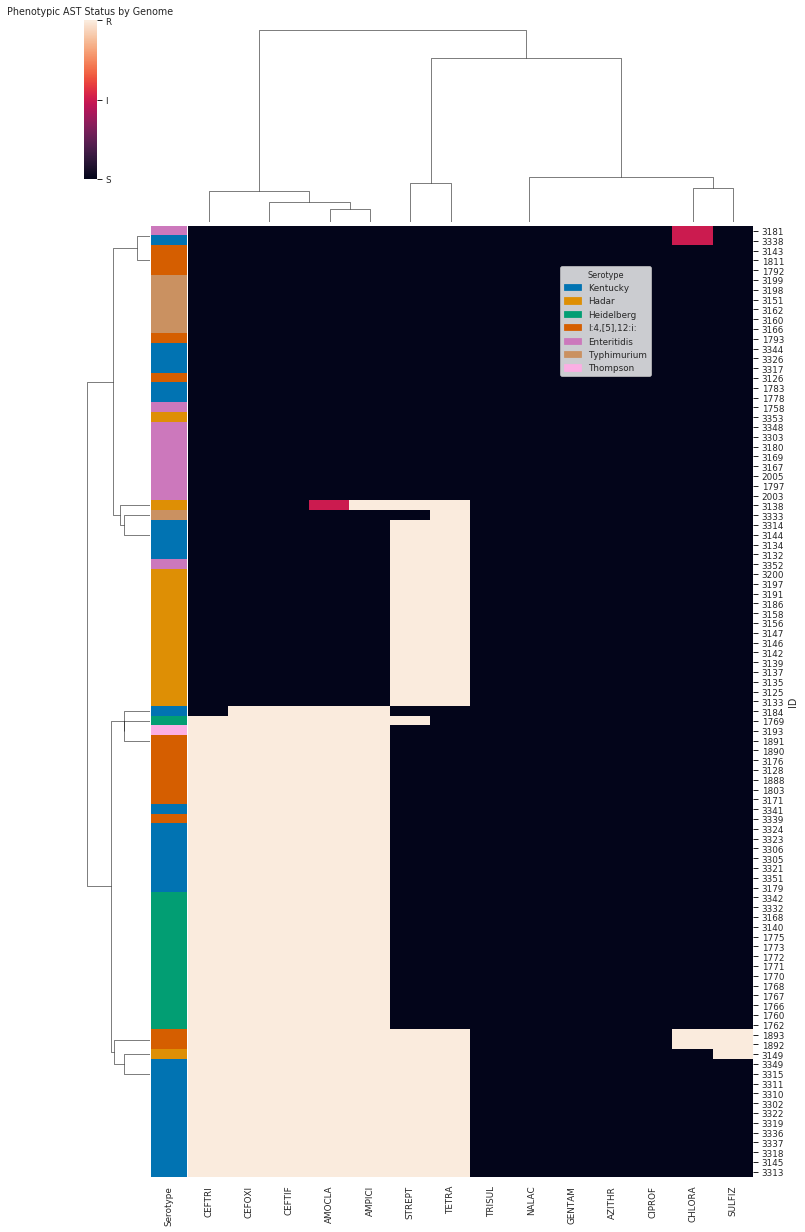

In [18]:
# tidy up to just the genomes we have phenotypes for
ast_df = pd.read_csv('data/antibiotic_susceptibility_testing/Salmonella_Source_AST_Sep 19_2018_sir.tsv', 
                     sep='\t')
ast_df['ID'] = ast_df['ID'].astype(int).astype(str)
ast_df = ast_df.set_index('ID')

# as these two don't have genomes
ast_df = ast_df.drop(['3346', '3163'])

ast_df = ast_df.drop(['Sample #', 'Serotype', 'Source Farm Code', 'Date Read'], axis=1)

ast_df.to_pickle('analyses/ast/ast.pkl')

ast_df['Serotype'] = metadata_df['Serotype']

# set consistent colors for serotype
sero_order = ['Kentucky', 'Hadar', 'Heidelberg', 
                     'I:4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson']
sero_lut = dict(zip(['Kentucky', 'Hadar', 'Heidelberg', 
                     'I:4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson'], sns.color_palette().as_hex()))

sir_labels = ast_df.loc[:, 'AMOCLA': 'TRISUL']
sir_labels[ast_df == 'S'] = 0
sir_labels[ast_df == 'I'] = 1
sir_labels[ast_df == 'R'] = 2
sir_labels = sir_labels.apply(pd.to_numeric)

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

import matplotlib.patches as mpatches
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

g = sns.clustermap(sir_labels, row_colors=colors, cbar_kws={'ticks': [0,1,2]}, xticklabels=True, 
                   yticklabels=True, figsize=(12,22))


plt.yticks([0,1,2], ['S', 'I', 'R'])
plt.title("Phenotypic AST Status by Genome")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.65,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
plt.subplots_adjust(bottom=0.15)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig('analyses/ast/astsummaryclustermap.svg')
plt.savefig('analyses/ast/astsummaryclustermap.pdf')

In [19]:
melt_ast = pd.melt(ast_df, id_vars='Serotype', var_name='Antimicrobial', value_name='SIR')
melt_ast.groupby(['Antimicrobial', 'Serotype'])['SIR'].value_counts()

Antimicrobial  Serotype       SIR
AMOCLA         Enteritidis    S      11
               Hadar          S      15
                              I       1
                              R       1
               Heidelberg     R      15
               I:4,[5],12:i:  R      10
                              S       5
               Kentucky       R      21
                              S      10
               Thompson       R       1
               Typhimurium    S       7
AMPICI         Enteritidis    S      11
               Hadar          S      15
                              R       2
               Heidelberg     R      15
               I:4,[5],12:i:  R      10
                              S       5
               Kentucky       R      21
                              S      10
               Thompson       R       1
               Typhimurium    S       7
AZITHR         Enteritidis    S      11
               Hadar          S      17
               Heidelberg     S      15
      

Create upset plots using `ast_upset_plot.r`

Final figure was then combined in inkscape

In [20]:
ast_df.drop(['Serotype'], axis=1).replace('I', 0).replace('R', 1).replace('S', 0).to_csv('analyses/ast/ast_sir_labels.csv')
#!R CMD BATCH analyses/ast/ast_upset_plot.r
# to plot all the upset plots

## Core Genome Phylogeny

- Generate core-genome SNP alignment using `roary` and `prokka` output with runner script `analyses/phylogeny/run_roary.sh`

- Generate phylogeny using IQTree

- Annotate phylogeny with `analyses/phylogeny/annotate_serotype.py`

## AMR Identification via RGI

Run RGI on all genomes using `analyses/run_rgi_on_genomes.sh`


In [21]:
rgi_results = []
missing = []
for assembly_id in ast_df.index:
    rgi_output = glob('analyses/rgi/{}_irida-submission-*.fasta_rgi.txt'.format(assembly_id))
    if len(rgi_output) == 1:
        df = pd.read_csv(rgi_output[0], sep='\t')
        df['ID'] = assembly_id
        rgi_results.append(df)
    elif len(rgi_output) > 1:
        print("Multiple hits")
    else:
        missing.append(assembly_id)

print("Genome with AST but no data downloaded from IRIDA ID:{}".format(missing))
        
rgi_results = pd.concat(rgi_results)
rgi_results = rgi_results.reset_index()
rgi_results = rgi_results.set_index('ID')
rgi_results = rgi_results.drop('index', axis=1)

#Then discard all AST data where we don't have a genome
ast_df = ast_df.drop(missing, axis=0)

Genome with AST but no data downloaded from IRIDA ID:[]


In [32]:
def get_drug_classes_and_families_by_ID(df):
# gather up the drug classes and gene families by ID
# fill na with '' empty string to avoid issues with pd.nan being a float
    drug_class = {}
    gene_family = {}
    for row in df.fillna('').iterrows():
        if row[0] not in drug_class:
            drug_class.update({row[0]: [row[1]['Drug Class']]})
        else:
            drug_class[row[0]].append(row[1]['Drug Class'])
        if row[0] not in gene_family:
            gene_family.update({row[0]: [row[1]['AMR Gene Family']]})
        else:
            gene_family[row[0]].append(row[1]['AMR Gene Family'])


    for key, value in drug_class.items():
        resistances = []
        for drug_list in value:
            for drug in drug_list.split(';'):
                if len(drug) != 0: 
                    resistances.append(drug.strip())

        drug_class[key] = resistances


    for key, value in gene_family.items():
        families = []
        for family_list in value:
            for family in family_list.split(';'):
                families.append(family.strip())

        gene_family[key] = families
        
    return drug_class, gene_family

def get_drug_class_df(drug_class_dict):
    all_drug_classes = set()
    for drug_set in list(drug_class_dict.values()):
        all_drug_classes = all_drug_classes.union(drug_set)

    df = pd.DataFrame(index=drug_class_dict.keys(), columns=all_drug_classes)
    df = df.fillna(0)
    for genome_id, drug_resistances in drug_class_dict.items():
        for drug in drug_resistances:
            df.loc[genome_id, drug] += 1
    
    return df
    
drug_class, gene_family = get_drug_classes_and_families_by_ID(rgi_results)
perfect_drug_class, \
perfect_gene_family = get_drug_classes_and_families_by_ID(rgi_results[rgi_results['Cut_Off']=='Perfect'])

In [193]:
clean_names = {'Escherichia coli GlpT with mutation conferring resistance to fosfomycin': 'GlpT mutation',
'Escherichia coli UhpT with mutation conferring resistance to fosfomycin': 'UhpT mutation',
'Escherichia coli acrA': 'acrA',
'Escherichia coli marR mutant conferring antibiotic resistance': 'marR mutation',
'Escherichia coli mdfA': 'mdfA',
'Escherichia coli soxR with mutation conferring antibiotic resistance': 'soxR mutation',
'Escherichia coli soxS with mutation conferring antibiotic resistance': 'soxS mutation', 
'Haemophilus influenzae PBP3 conferring resistance to beta-lactam antibiotics': 'PBP3',
'Salmonella enterica ramR mutants': 'ramR mutation'}

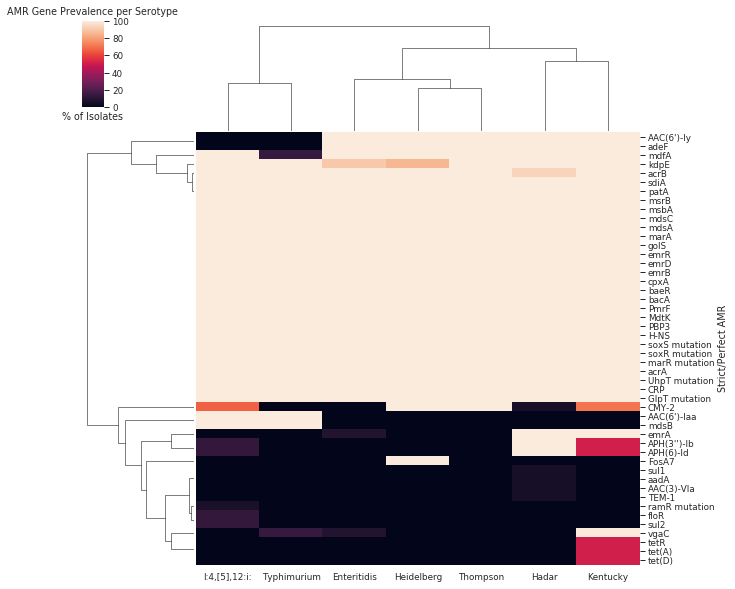

In [216]:
df.index.name = 'Strict/Perfect AMR'
sns.clustermap(df.rename(clean_names))
plt.xlabel('% of Isolates')
plt.title('AMR Gene Prevalence per Serotype')
plt.savefig('amr_genes.svg')

## Prediction

### Direct Tallying from Genotyping to AST

Essential Agreement (EA): Agreement within plus or minus one two-fold dilution of reference MIC;

Category Agreement (CA): Agreement of interpretive results (Susceptible (S), Intermediate (I), or Resistant (R));

major discrepancy (maj): The reference category result is S and the new method result is R; and very major discrepancy; 
and (vmj): The reference category result is R and the new method result is S.

In [58]:
# from the card database assuming nalac is nalidixic acid
drug_class_translation = {'AMOCLA':  ['penam'],
                          'AMPICI': ['penam'],
                          'AZITHR': ['macrolide antibiotic'],
                          'CEFOXI': ['cephamycin'],
                          'CEFTIF': ['cephalosporin'],
                          'CEFTRI': ['cephalosporin'],
                          'CHLORA': ['phenicol antibiotic'],
                          'CIPROF': ['fluoroquinolone antibiotic'],
                          'GENTAM': ['aminoglycoside antibiotic'],
                          'NALAC':  ['fluoroquinolone antibiotic'],
                          'STREPT': ['aminoglycoside antibiotic'],
                          'SULFIZ': ['sulfonamide antibiotic'],
                          'TETRA':  ['tetracycline antibiotic'],
                          'TRISUL': ['sulfonamide antibiotic', 'diaminopyrimidine antibiotic']}

# get reverse lookup
drug_class_translation_rev = {}
for key, value in drug_class_translation.items():
    for rgi_drug in value:
        if rgi_drug not in drug_class_translation_rev:
            drug_class_translation_rev.update({rgi_drug : [key]})
        else:
            drug_class_translation_rev[rgi_drug].append(key)


In [65]:
# drop Efflux pumps
rgi_sir_no_efflux = pd.DataFrame(index=ast_df.index, columns=ast_df.columns)
rgi_sir_no_efflux['Serotype'] = ast_df.loc[rgi_sir.index, 'Serotype']


efflux = ['ATP-binding cassette (ABC) antibiotic efflux pump',
          'major facilitator superfamily (MFS) antibiotic efflux pump',
          'resistance-nodulation-cell division (RND) antibiotic efflux pump']


df = rgi_results[(~rgi_results['AMR Gene Family'].str.startswith(efflux[0]))]
df = df[~(df['AMR Gene Family'].str.startswith(efflux[1]))]
df = df[~(df['AMR Gene Family'].str.startswith(efflux[2]))]

for row in df.iterrows():
    ix = row[0]
    data = row[1]
    if type(data['Drug Class']) == float:
        print(data['Best_Hit_ARO'], ' missing drug class information')
        data['Drug Class'] = ''
    drug_classes = [x.strip() for x in data['Drug Class'].split(';')]
    for drug in drug_classes:
        if drug in drug_class_translation_rev:
            for ast_class in drug_class_translation_rev[drug]:
                rgi_sir_no_efflux.loc[ix,ast_class] = 'R'
        # add drug classes not in the ast 
        else:
            if drug not in rgi_sir.columns:
                rgi_sir_no_efflux[drug] = np.nan
                rgi_sir_no_efflux.loc[ix, drug] = 'R'
            else:
                rgi_sir_no_efflux.loc[ix, drug] = 'R'

# genotypically all the missing are 'S'
rgi_sir_no_efflux = rgi_sir_no_efflux.fillna('S')

ast is R = 1 genome is R = 1 = 0 CA
             genome is S = 0 = 1 Very Major
ast is S = 0 genome is S = 0 = 0 CA
            genome is R = 1 = -1 Major

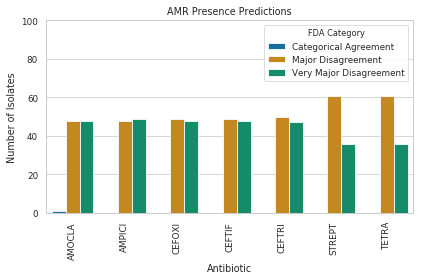

In [68]:
drugs = [x for x in drug_class_translation.keys() if x not in ['AZITHR', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'SULFIZ', 'TRISUL']]
df = ast_df.drop(['AZITHR', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'SULFIZ', 'TRISUL', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir.loc[:, drugs].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, iddd_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('AMR Presence Predictions')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('analyses/rgi/fda_drug.svg')

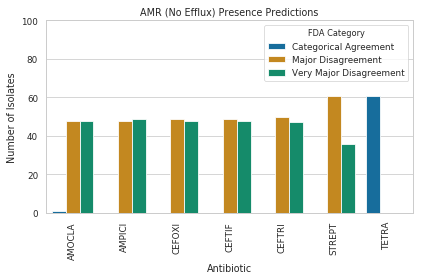

In [69]:
drugs = [x for x in drug_class_translation.keys() if x not in ['AZITHR', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'SULFIZ', 'TRISUL']]
df = ast_df.drop(['AZITHR', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'SULFIZ', 'TRISUL', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir_no_efflux.loc[:, drugs].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('AMR (No Efflux) Presence Predictions')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('analyses/rgi/fda_drug_no_efflux.svg')

In [ ]:
df = ast_df.drop(['Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('Correspondence between AMR (strict+perfect) Determinants and AST')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('analyses/rgi/fdadrug.pdf')

In [ ]:
rgi_sir

In [ ]:
df = ast_df.drop(['Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir_no_efflux.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('Correspondence between AMR (strict+perfect) Determinants and AST')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('analyses/rgi/fdadrug.pdf')

In [ ]:
def tally_FDA(rgi_df, ast_df):
    drugs = ['AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI',
       'CEFTIF', 'CEFTRI', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'STREPT',
       'SULFIZ', 'TETRA', 'TRISUL']
    fda_perf = pd.DataFrame(index=ast_df.index, columns = ['Categorical Agreement',
                                                           'Major Disagreement',
                                                           'Very Major Disagreement'])
    fda_perf = fda_perf.fillna(0)
    fda_perf['Serovar'] = ast_df['Serotype']
    
    rgi_df = rgi_df.loc[:, drugs]
    ast_df = ast_df.drop('Date Read', axis=1).loc[:, drugs]
    
    # as we aren't predicting 'I'
    ast_df = ast_df.replace('I', 'R')
    
    # to just go over the cols with ast results
    for ix, ast in ast_df.loc[:, drugs].iterrows():
        for drug, sir in ast.iteritems():
            if sir == rgi_df.loc[ix, drug]:
                fda_perf.loc[ix, 'Categorical Agreement'] += 1 
            elif sir == 'S' and rgi_df.loc[ix, drug] == 'R':
                fda_perf.loc[ix, 'Major Disagreement'] += 1
            elif sir == 'R' and rgi_df.loc[ix, drug] == 'S':
                fda_perf.loc[ix, 'Very Major Disagreement'] += 1
            else:
                assert False
    return fda_perf

fda_perf = tally_FDA(rgi_sir, ast_df) 
fda_perf_perfect = tally_FDA(rgi_sir_perfect, ast_df)

In [ ]:
df = pd.melt(fda_perf, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.title('Performance of Genomic AMR against AST')
plt.ylabel('Number of Isolates')
#save_figure('amr/fda_rgi_amr')
plt.tight_layout()
plt.savefig('analyses/rgi/fdaamr.pdf')

In [ ]:
df = pd.melt(fda_perf_perfect, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.title('Performance of Genomic AMR (Perfect) against AST')

plt.ylabel('Number of Isolates')
#save_figure('amr/fda_rgi_amr_perfect')
plt.tight_layout()
_ = plt.xticks(rotation=45)
plt.savefig('analyses/rgi/fdaamrperfect.pdf')

In [ ]:
fda_perf

So relatively good but with 'strict' its basically resistant to everything therefore the no vmaj. Perfect seems to be more reasonable.  Interesting that Typhmimurium and Enteriditis are so bad even with perfect cut_off.

In [ ]:
print(rgi_sir_perfect.columns)
print(rgi_sir.columns)

Might also be worth testing drugs from 'monobactam', 'carbapenem', 'penem', 'sulfone antibiotic',
       'fosfomycin', 'glycylcycline', 'rifamycin antibiotic', 'triclosan' as these had perfect hits but no AST data
       
emrD is also an unknown factor

## Logistic Regression 

AKA can this be improved by not using the RGI drug classes directly but by training a classifier.

In [ ]:
from sklearn.model_selection import train_test_split

# to make it useable and encode it
sr_ast = ast_df.drop(['Serotype', 'Date Read'], axis=1)
sr_ast = sr_ast.replace('S', 0)
sr_ast = sr_ast.replace('I', 1)
sr_ast = sr_ast.replace('R', 1)

rgi_train, rgi_test, sr_train, sr_test = train_test_split(rgi_encoded.as_matrix(), 
                                                             sr_ast.as_matrix(), 
                                                             test_size=0.25, 
                                                             random_state=42)

rgi_perfect_train, rgi_perfect_test, sr_train, sr_test = train_test_split(rgi_encoded_perfect.drop('Serotype', axis=1).as_matrix(), 
                                                                          sr_ast.as_matrix(), 
                                                                          test_size=0.25, 
                                                                          random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV


def compare_clf(X_train, X_test, y_train, y_test):

    names = ["DT", "ET", "ETs", "RF",
             "KN", "RN", "MLP", "RC"]

    classifiers = [
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        ExtraTreesClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(), 
        MLPClassifier()]
        # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print(name, clf.score(X_test, y_test))
     
        

In [ ]:
compare_clf(rgi_train, rgi_test, sr_train, sr_test)

In [ ]:
compare_clf(rgi_perfect_train, rgi_perfect_test, sr_train, sr_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
rf_r_cv.fit(rgi_train, sr_train)

In [ ]:
report(rf_r_cv.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

perf_rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
perf_rf_r_cv.fit(rgi_perfect_train, sr_train)

In [ ]:
report(perf_rf_r_cv.cv_results_)

So best performing RF is: n_estimators': 70, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False

In [ ]:
clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)
perf_clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)

clf.fit(rgi_train, sr_train)
perf_clf.fit(rgi_perfect_train, sr_train)

print('ALL RGI')
print(metrics.classification_report(clf.predict(rgi_test), sr_test, target_names=sr_ast.columns))

print('Perfect RGI')
print(metrics.classification_report(perf_clf.predict(rgi_perfect_test), sr_test, target_names=sr_ast.columns))

In [ ]:
ml_prediction = clf.predict(rgi_encoded)
ml_prediction = pd.DataFrame(ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serotype', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')

perf_ml_prediction = perf_clf.predict(rgi_encoded_perfect.drop('Serotype', axis=1))
perf_ml_prediction = pd.DataFrame(perf_ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serotype', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')


In [ ]:
ml_fda = tally_FDA(ml_prediction, ast_df)
perf_ml_fda = tally_FDA(perf_ml_prediction, ast_df)

In [ ]:
df = pd.melt(ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction')
#save_figure('amr/rf_ast_prediction_fda')

In [ ]:
df = pd.melt(perf_ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction (Perfect Only)')
_ = plt.xticks(rotation=45)
#save_figure('amr/rf_ast_prediction_perfect_fda')

In [ ]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded.columns[f], importances[indices[f]]))

# broken ccurrently to fix
# Plot the feature importances of the forest
#plt.figure(figsize=(10,5))
#plt.title("RandomForest AST Prediction Feature Importances")
##plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.xticks(range(X.shape[1]), rgi_encoded.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.show()
#save_figure('amr/rf_feature_importances')

Worrying that emrD is so important despite not being associated with a drug class in CARD

In [ ]:
importances = perf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded_perfect.drop('Serotype', axis=1)
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded_perfect.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("RandomForest AST Prediction Feature Importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

#plt.xticks(range(X.shape[1]), rgi_encoded_perfect.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.show()
#save_figure('amr/rf_perfect_feature_importances')

Suspect this is probably overfitted to all hell.

## Set Covering Machine 

Let's see how well we can perform without RGI labelling by just directly applying Kover/set covering machine approach to the contigs.

Might be interesting/redundant to use the methods used in https://www.biorxiv.org/content/biorxiv/early/2018/06/04/338194.full.pdf

Kover requires TSVs of the genomes `Genome_ID\tFasta_Path` and the metadata: separate files for each antibiotic `Genome_ID\t[1,0]` depending on resistance status

Let's try just cefotaxin first as its a the human alternative antibiotic of choice for Salmonella that we have in our dataset and has resistance (Ciprofloxacin is first choice but no resistance in our taxa)
`./kover/bin/kover dataset create from-contigs --genomic-data metadata/genome_metadata.tsv --phenotype-name cefotaxin --phenotype-metadata metadata/CEFOXI_metadata.tsv --output cefotaxin_dataset -x --n-cpu 1`

In [70]:
# get our RGI hit DNA sequences out and map our 'rules' to them using bwa
out_fh = open('analyses/kover/rgi_hits_dna.fasta', 'w')
for ix, seq in rgi_results[['ARO', 'Best_Hit_ARO', 'Predicted_DNA']].drop_duplicates().sort_values('Best_Hit_ARO').groupby('ARO').head(1).iterrows():
    out_fh.write('>{}_{}\n{}\n'.format(seq['ARO'], seq['Best_Hit_ARO'], seq['Predicted_DNA']))
out_fh.close()

`bash map_to_rgi.sh` to use BWA mem to map our rules to the RGI seqs

In [89]:
import pysam
from collections import Counter

model_counts = {'Antibiotic': [], 
                '31-mer Location': [],
                'Count': []}

for model in glob('analyses/kover/*.sam'):
    abx = model.split('/')[2].replace('.sam', '').split('_')[0]
    sam = pysam.Samfile(model)
    hits = []
    for entry in sam:
        rule_type = entry.query_name.split(',')[1]
        if rule_type != 'presence':
            assert False
        if entry.flag == 4:
            hits.append("Non-Predicted AMR Loci")
        else:
            hits.append("_".join(entry.reference_name.split('_')[1:]))
    
    hits = dict(Counter(hits))
    for hit, count in hits.items():
        model_counts['Antibiotic'].append(abx)
        model_counts['31-mer Location'].append(hit)
        model_counts['Count'].append(count)
        
kover_df = pd.DataFrame(model_counts)

norm = kover_df.groupby('Antibiotic')['Count'].sum()
df = kover_df.set_index('Antibiotic')
df['total'] = norm
df['Proportion of 31-mers']  = df['Count'] / df['total'] * 100
df = df.reset_index()

In [309]:
import pysam
from collections import Counter

model_counts = {'Antibiotic': [], 
                '31-mer Location': [],
                'Count': []}

for model in glob('analyses/kover/*_all_genes.sam'):
    abx = model.split('/')[2].replace('.sam', '').split('_')[0]
    sam = pysam.Samfile(model)
    hits = []
    for entry in sam:
        rule_type = entry.query_name.split(',')[1]
        if rule_type != 'presence':
            assert False
        if entry.flag == 4:
            hits.append("Non-Gene Loci")
        else:
            hits.append(entry.reference_name)
    
    hits = dict(Counter(hits))
    for hit, count in hits.items():
        model_counts['Antibiotic'].append(abx)
        model_counts['31-mer Location'].append(hit)
        model_counts['Count'].append(count)
        
kover_df = pd.DataFrame(model_counts)

norm = kover_df.groupby('Antibiotic')['Count'].sum()
df = kover_df.set_index('Antibiotic')
df['total'] = norm
df['Proportion of 31-mers']  = df['Count'] / df['total'] * 100
df = df.reset_index()

In [324]:
!fasta_formatter -i analyses/kover/all_genes_clustered -o analyses/kover/all_genes_clustered.ffn

In [357]:
df.to_csv('analyses/kover/hits.csv')

In [355]:
a = pd.read_csv('analyses/kover/2018-12-07_18:27:06.024_kmer_hits.ffn.txt', sep='\t')
a['Contig'] = a['Contig'].str.replace('_1', '')
a = a.set_index('Contig')
a['Best_Hit_ARO']


Contig
KIKMHIFC_04044          CMY-2
FMCEEJOD_04609    APH(3'')-Ib
LOJAHKHP_04336    APH(3'')-Ib
FMCEEJOD_04610      APH(6)-Id
Name: Best_Hit_ARO, dtype: object

In [389]:
df.sort_values(['Antibiotic', 'Proportion of 31-mers'])

,Antibiotic,Gene Name,Count,total,Proportion of 31-mers
3,AMOCLA,SugE,290,2390,12.133891
2,AMOCLA,Non-Gene Loci,434,2390,18.158996
0,AMOCLA,Blc,497,2390,20.794979
1,AMOCLA,CMY-2,1085,2390,45.397490
5,AMPICI,Non-Gene Loci,366,1565,23.386581
4,AMPICI,CMY-2,1088,1565,69.520767
7,CEFOXI,Non-Gene Loci,366,1565,23.386581
6,CEFOXI,CMY-2,1088,1565,69.520767
9,CEFTIF,Non-Gene Loci,366,1565,23.386581
8,CEFTIF,CMY-2,1088,1565,69.520767


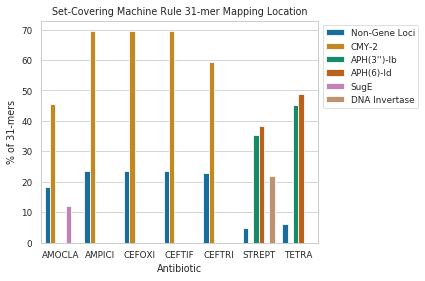

In [387]:
sns.set_context('paper')
df = pd.read_csv('analyses/kover/hits.csv')
df = df.groupby(['Antibiotic', 'Gene Name']).sum()
df = df.reset_index()
sns.barplot(data = df, x='Antibiotic', hue='Gene Name', y='Proportion of 31-mers', hue_order=['Non-Gene Loci', 
                                                                                              'CMY-2',
                                                                                             "APH(3'')-Ib",
                                                                                             "APH(6)-Id",
                                                                                             "SugE",
                                                                                             'DNA Invertase'])
plt.title('Set-Covering Machine Rule 31-mer Mapping Location')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.ylabel('% of 31-mers')
plt.savefig('kover_mapping_location.svg')
plt.savefig('kover_mapping_location.pdf')

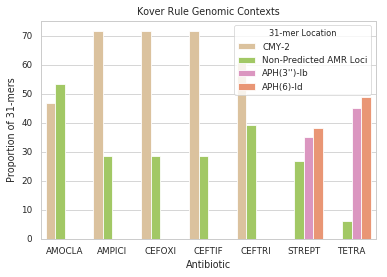

In [73]:
sns.barplot(data = df, y = 'Proportion of 31-mers', x='Antibiotic', palette='Set2_r', hue='31-mer Location', order=df['Antibiotic'].sort_values().drop_duplicates())
plt.title('Kover Rule Genomic Contexts')
plt.savefig('analyses/kover/kover_locs.svg')


In [74]:
kover_perf_df = {'Antibiotic': [], 'Precision': [], 'Recall': [], 'Categorical Agreement': [],
                'Major Disagreement': [], 'Very Major Disagreement': []}

missclassifications = []
for model in glob('analyses/kover/*/results.json'):
    abx = model.split('/')[2].split('_')[0]
    kover_perf_df['Antibiotic'].append(abx)
    with open(model) as fh:
        report = json.load(fh)
        
        for entry in report['classifications']['test_errors'] + report['classifications']['train_errors']:
            missclassifications.append([abx, entry])
        kover_perf_df['Precision'].append(report['metrics']['test']['precision'][0])
        kover_perf_df['Recall'].append(report['metrics']['test']['recall'][0])
        
        kover_perf_df['Categorical Agreement'].append(report['metrics']['test']['tp'][0] + \
                                                     report['metrics']['test']['tn'][0] + \
                                                      report['metrics']['train']['tp'][0] + \
                                                     report['metrics']['train']['tn'][0])
        
                
        kover_perf_df['Major Disagreement'].append(report['metrics']['test']['fp'][0] + \
                                                     report['metrics']['train']['fp'][0])
                        
        kover_perf_df['Very Major Disagreement'].append(report['metrics']['test']['fn'][0] + \
                                                     report['metrics']['train']['fn'][0])
        
kover_perf_df = pd.DataFrame(kover_perf_df)

In [291]:
kover_perf_df

,Antibiotic,Categorical Agreement,Major Disagreement,Precision,Recall,Very Major Disagreement
0,AMPICI,93,2,0.916667,1.000000,2
1,STREPT,92,2,1.000000,0.928571,3
2,CEFOXI,94,2,0.900000,0.900000,1
3,AMOCLA,93,2,1.000000,0.909091,2
4,CEFTRI,93,3,1.000000,1.000000,1
5,TETRA,92,2,0.909091,0.909091,3
6,CEFTIF,94,2,0.937500,1.000000,1


In [76]:
kover_miss = pd.DataFrame(missclassifications, columns=['Antibiotic', 'Genome'])
lr_miss = pd.read_pickle('analyses/logistic_regression/misclass')

In [77]:
df = pd.concat([lr_miss, kover_miss])
wrong_both = df[df.duplicated()]

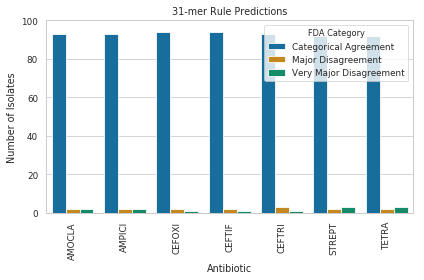

In [86]:
df = pd.melt(kover_perf_df.drop(['Precision', 'Recall'], axis=1), id_vars='Antibiotic', var_name='FDA Category', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], 
            order = df['Antibiotic'].sort_values().drop_duplicates(), data = df)
plt.title('31-mer Rule Predictions')
plt.ylabel("Number of Isolates")
plt.xlabel('Antibiotic')
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('analyses/kover/kover_plot.svg')



In [87]:
kover_perf_df

,Antibiotic,Categorical Agreement,Major Disagreement,Precision,Recall,Very Major Disagreement
0,AMPICI,93,2,0.916667,1.000000,2
1,STREPT,92,2,1.000000,0.928571,3
2,CEFOXI,94,2,0.900000,0.900000,1
3,AMOCLA,93,2,1.000000,0.909091,2
4,CEFTRI,93,3,1.000000,1.000000,1
5,TETRA,92,2,0.909091,0.909091,3
6,CEFTIF,94,2,0.937500,1.000000,1


ast is R = 1 genome is R = 1 = 0 CA
             genome is S = 0 = 1 Very Major
ast is S = 0 genome is S = 0 = 0 CA
            genome is R = 1 = -1 Major

In [ ]:
precision_df = pd.DataFrame(index=kover_perf_df['Antibiotic'])
precision_df['Kover'] = kover_perf_df.set_index('Antibiotic')['Precision']
precision_df['Logistic Regression'] = lr_av_prec

In [ ]:
df = rgi_sir_no_efflux[precision_df.index] == ast_df[precision_df.index]
df['AMPICI'].value_counts()

In [ ]:
rgi_no_efflux = {'Antibiotic': [], 'Precision': []}
for abx in ast_df[kover_perf_df['Antibiotic']]:
    
    true_resistant = 0
    pred_resistant = 0
    for ix in ast_df.index:
        if ast_df.loc[ix, abx] == 'R' and rgi_sir_no_efflux.loc[ix, abx] == 'R':
            true_resistant += 1
        if rgi_sir_no_efflux.loc[ix, abx] == 'R':
            pred_resistant += 1
    if pred_resistant == 0:
        precision = 0
    else:
        precision = true_resistant / pred_resistant
    rgi_no_efflux['Antibiotic'].append(abx)
    rgi_no_efflux['Precision'].append(precision)
    
    

In [ ]:
rgi_prec = {'Antibiotic': [], 'Precision': []}
for abx in ast_df[kover_perf_df['Antibiotic']]:
    
    true_resistant = 0
    pred_resistant = 0
    for ix in ast_df.index:
        if ast_df.loc[ix, abx] == 'R' and rgi_sir.loc[ix, abx] == 'R':
            true_resistant += 1
        if rgi_sir.loc[ix, abx] == 'R':
            pred_resistant += 1
    if pred_resistant == 0:
        precision = 0
    else:
        precision = true_resistant / pred_resistant
    rgi_prec['Antibiotic'].append(abx)
    rgi_prec['Precision'].append(precision)
    
    

In [ ]:
precision_df['AMR Genes'] = pd.DataFrame(rgi_prec).set_index('Antibiotic')
precision_df['AMR Genes (No Efflux)'] = pd.DataFrame(rgi_no_efflux).set_index('Antibiotic')

In [ ]:
sns.barplot(data = pd.melt(precision_df.reset_index(), id_vars='Antibiotic', var_name='Method', value_name='Precision'),
            x = 'Antibiotic', hue='Method', y='Precision', order=kover_perf_df['Antibiotic'].sort_values())

plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('analyses/precision.svg')
plt.savefig('analyses/precision.pdf')

## Assembly Summary

In [ ]:
assembly_summary = {'ID': [], 'Total Size': [], 'Number of Contigs': [], 
                   'Longest Contig': [], 'Average Contig Size': [], 
                   'N50': []}
with open('analyses/assemblies/assembly') as fh:
    for line in fh:
        if line[0].isdigit():
            genome = line.strip().split('_')[0]
        elif line.startswith('sum'):
            overall = line.strip().split(',')
            total = overall[0].replace('sum = ', '')
            contig_count = overall[1].replace(' n = ', '')
            average = overall[2].replace(' ave = ', '')
            biggest = overall[3].replace(' largest = ', '')
        elif line.startswith('N50'):
            n50 = line.split(',')[0].replace('N50 = ', '')
        elif line.strip() == '':
            assembly_summary['ID'].append(genome)
            assembly_summary['Total Size'].append(int(total))
            assembly_summary['Number of Contigs'].append(int(contig_count))
            assembly_summary['Longest Contig'].append(int(biggest))
            assembly_summary['Average Contig Size'].append(float(average))
            assembly_summary['N50'].append(float(n50))
            
assembly_stats = pd.DataFrame(assembly_summary).set_index('ID')

In [ ]:
n50_comp = pd.DataFrame()
n50_comp['N50'] = assembly_stats['N50'].reset_index().drop('ID', axis=1)
n50_comp['Type'] = 'All Assemblies'

a = pd.DataFrame()
a['N50'] = assembly_stats.loc[ag['Genome'].drop_duplicates().values]['N50'].values
a['Type'] = 'TETRA/STREPT'

b = pd.DataFrame()
b['N50'] = assembly_stats.loc[bl['Genome'].drop_duplicates().values]['N50'].values
b['Type'] = 'Beta-Lactam'

n50_comp = pd.concat([n50_comp, a, b])
sns.violinplot(data = n50_comp, x='Type', y='N50')
#plt.xticks(rotation=90)
plt.xlabel("Assembly Groups")
plt.title("Mispredicted Genome Characteristics")
plt.ylabel('N50 (bp)')
plt.tight_layout()
#plt.savefig('analyses/assemblies/n50.svg')
#plt.savefig('figures/final_figures/n50.svg')
#plt.savefig('figures/final_figures/n50.pdf')